In [48]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import cna
import pp, pf
plt.style.use('../pp.mplstyle')
np.random.seed(0) # for reproducibility

## harmonized data

In [6]:
print('reading')
mrna = cna.read(pf.tbru_h5ad + 'harmmrna.h5ad')
prot = cna.read(pf.tbru_h5ad + 'harmprot.h5ad')
cca = cna.read(pf.tbru_h5ad + 'harmcca20.h5ad')

for d in [mrna, prot, cca]:
    print('processing...')
    d.obs_to_sample(['batch', 'nUMI', 'percent_mito'])
    cna.tl.nam(d, batches=d.samplem.batch, covs=d.samplem[['nUMI','percent_mito']], force_recompute=True)
    sc.tl.pca(d)

reading
processing...
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 65.2238540649414
	taking step 2
	median kurtosis: 49.052650451660156
	taking step 3
	median kurtosis: 28.971097946166992
	taking step 4
	median kurtosis: 18.28443145751953
	taking step 5
	median kurtosis: 11.800000190734863
	taking step 6
	median kurtosis: 8.272377014160156
	taking step 7
	median kurtosis: 6.357010364532471
stopping after 7 steps
throwing out neighborhoods with batch kurtosis >= 7.22025203704834
keeping 447296 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  3.6042004997911032
computing SVD
processing...
qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 62.95005798339844
	taking step 2
	median kurtosis: 46.884666442871094
	taking step 3
	median kurtosis: 28.252164840698242
	taking step 4
	median kurtosis: 18.792322158813477
	taking step 5
	median kurtosis: 13.07491683959961
	taking step 6

In [62]:
# read in innateness scores
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
innateness = readRDS('/data/srlab1/laurie-yakir/tbru.real/innate.scores_01.12.rds')

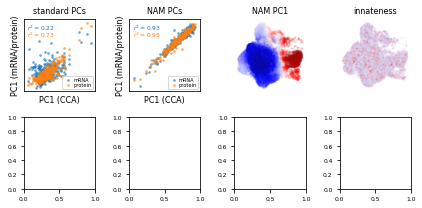

In [64]:
f, axs = plt.subplots(2, 4, figsize=(6,3))

# compare standard PC1 across modalities
ax = axs[0,0]
for i, (d, l, c) in enumerate([(mrna, 'mRNA', 'C0'), (prot, 'protein', 'C1')]):
    d.obs['PC1'] = d.obsm['X_pca'][:,0]
    cca.obs['PC1'] = cca.obsm['X_pca'][:,0]
    x, y = cca.obs.groupby(by='id').PC1.aggregate(np.mean), d.obs.groupby(by='id').PC1.aggregate(np.mean)
    x = x/x.std(); y = y/y.std()
    ax.scatter(x, y, alpha=0.5, s=3, color=c, label=l)
    ax.text(0.05, 0.85-i/10, '$r^2 = {:.2f}$'.format(np.corrcoef(x,y)[0,1]**2),
            transform=ax.transAxes,
            fontsize=6,
            color=c)
    ax.set_ylabel('PC1 (mRNA/protein)')
    ax.set_xlabel('PC1 (CCA)')
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(loc=4)
ax.set_title('standard PCs', fontsize=8)

# compare NAM PC1 across modalities
ax = axs[0,1]
for i, (d, l, c) in enumerate([(mrna, 'mRNA', 'C0'), (prot, 'protein', 'C1')]):
    x, y = cca.uns['NAM_sampleXpc'].PC1, d.uns['NAM_sampleXpc'].PC1
    ax.scatter(x, y, alpha=0.5, s=3, color=c, label=l)
    ax.set_ylabel('PC1 (mRNA/protein)')
    ax.set_xlabel('PC1 (CCA)')
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.05, 0.85-i/10, '$r^2 = {:.2f}$'.format(np.corrcoef(x,y)[0,1]**2),
            transform=ax.transAxes,
            fontsize=6,
            color=c)
    ax.legend(loc=4)
ax.set_title('NAM PCs', fontsize=8)

#UMAPs of NAM PC1
for ax, c, l in [(axs[0,2], -cca.uns['NAM_nbhdXpc'].PC1, 'NAM PC1'), (axs[0,3], innateness[cca.uns['keptcells']], 'innateness')]:
    ax.axis('off')
    umap = cca.obsm['X_umap'][cca.uns['keptcells']]
    ix = np.random.choice(range(len(umap)), 30000, replace=False) # downsample cells to make rasterized file size decent
    ax.scatter(*umap[ix].T, s=2, alpha=0.1, c=c[ix], cmap='seismic', vmin=-max(np.abs(c)), vmax=max(np.abs(c)))
    ax.set_title(l, fontsize=8)

plt.tight_layout()
plt.savefig('../_figs/mainfig.tbru.unsupervised.pdf')

In [33]:
# variance explained
for d in [mrna, prot, cca]:
    print(d.uns['NAM_varexp'][0])

0.23074752735913887
0.15241683973461584
0.24262001532194377


In [65]:
# correlation of NAM PC1 to innateness
np.corrcoef(-cca.uns['NAM_nbhdXpc'].PC1, innateness[cca.uns['keptcells']])[0,1]

-0.001640862051976084

In [66]:
cca.obs.head()

,nUMI,nGene,percent_mito,donor,id,batch,correct,memTgate,aparna0p4,aparna0p8,...,aparna2p0,aparna2p4,leiden0p1,leiden0p2,leiden0p5,leiden1,leiden2,leiden5,leiden10,PC1
cell_id,,,,,,,,,,,,,,,,,,,,,
ATTCATCGTTATGACC-34,5807,1862,0.057000,M0006310-8,M0006310-8-34,34,True,True,6,7,...,12,10,0,0,1,10,11,13,25,-0.747292
GAGGGATAGAGAACCC-34,3322,1044,0.129139,M0006310-8,M0006310-8-34,34,True,True,10,15,...,23,26,1,1,3,12,19,30,7,0.130878
GAGGCCTGTAACGCGA-34,2966,1108,0.096763,M0006310-8,M0006310-8-34,34,True,True,0,3,...,2,1,0,0,0,3,3,44,34,-0.513849
ATTCCATTCCACGTAA-34,5209,1663,0.067575,M0006310-8,M0006310-8-34,34,True,True,5,13,...,16,18,0,0,5,6,16,6,1,-0.487002
ATTCCATTCTTCGGAA-34,4972,1531,0.057120,M0006310-8,M0006310-8-34,34,True,True,7,5,...,11,11,0,0,7,7,7,12,42,0.185197


In [55]:
######################

mRNA 7 0.025830258302583026
protein 10 0.03690036900369004
CCA 5 0.01845018450184502


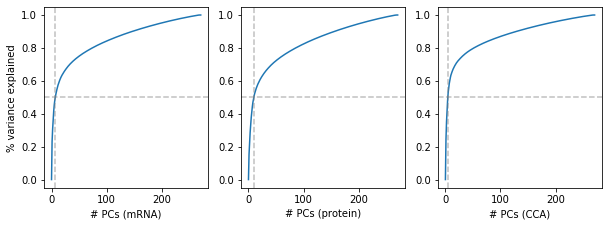

In [79]:
f, axs = plt.subplots(1,3, figsize=(10,3.33))

for ax, (d, l) in zip(axs, [(mrna, 'mRNA'), (prot, 'protein'), (cca, 'CCA')]):
    y = np.cumsum(np.concatenate([[0], d.uns['NAM_varexp']]))
    k = np.where(y >= 0.5)[0][0]
    print(l, k, k/271.)
    ax.plot(y)
    ax.axvline(x=k, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('# PCs ({})'.format(l))
axs[0].set_ylabel('% variance explained')
plt.show()

## non-harmonized data (mRNA only)

In [80]:
mrna_noharm = cna.read('/data/srlab1/laurie-yakir/tbru.real/2.munged/mrna.h5ad')
mrna_noharm.obs_to_sample(['batch', 'nUMI', 'percent_mito'])
mrna_noharm.samplem['age2'] = mrna_noharm.samplem.age**2
cna.tl.nam(mrna_noharm, batches=mrna_noharm.samplem.batch, covs=mrna_noharm.samplem[['nUMI','percent_mito']], force_recompute=True)

qcd NAM not found; computing and saving
	taking step 1
	median kurtosis: 96.45571363398902
	taking step 2
	median kurtosis: 66.11929593184762
	taking step 3
	median kurtosis: 39.18345633687962
	taking step 4
	median kurtosis: 25.279649521369095
	taking step 5
	median kurtosis: 17.538748734387784
	taking step 6
	median kurtosis: 13.218013844769336
	taking step 7
	median kurtosis: 10.665356323599964
stopping after 7 steps
throwing out neighborhoods with batch kurtosis >= 8.667603813822101
keeping 393998 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median batch kurtosis =  3.61557420585108
computing SVD


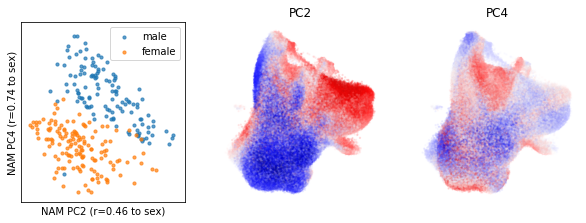

In [88]:
f, axs = plt.subplots(1,3, figsize=(10,3.3))

U, V = mrna_noharm.uns['NAM_sampleXpc'], mrna_noharm.uns['NAM_nbhdXpc']

i, j = 'PC2', 'PC4'
ax1 = axs[0]
male = mrna_noharm.samplem.Sex_M.astype(bool)
ax1.scatter(U[i][male], U[j][male], alpha=0.7, s=10, label='male')
ax1.scatter(U[i][~male], U[j][~male], alpha=0.7, s=10, label='female')
ax1.legend()
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlabel('NAM {} (r={:.2f} to sex)'.format(i, np.corrcoef(U[i], mrna_noharm.samplem.Sex_M)[0,1]))
ax1.set_ylabel('NAM {} (r={:.2f} to sex)'.format(j, np.corrcoef(U[j], mrna_noharm.samplem.Sex_M)[0,1]))

for ax, (c, l) in zip(axs[1:], [(V[i], i), (V[j], j)]):
    ax.axis('off')
    ax.scatter(*mrna_noharm.obsm['X_umap'][mrna_noharm.uns['keptcells']].T, s=2, alpha=0.1,
               c=c, cmap='seismic', vmin=-max(np.abs(c)), vmax=max(np.abs(c)))
    ax.set_title(l)

plt.show()

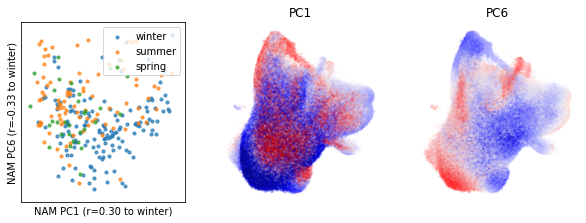

In [100]:
f, axs = plt.subplots(1,3, figsize=(10,3.3))

U, V = mrna_noharm.uns['NAM_sampleXpc'], mrna_noharm.uns['NAM_nbhdXpc']

i, j = 'PC1', 'PC6'
ax1 = axs[0]
winter = mrna_noharm.samplem.season_Winter.astype(bool)
summer = mrna_noharm.samplem.season_Summer.astype(bool)
spring = mrna_noharm.samplem.season_Spring.astype(bool)
ax1.scatter(U[i][winter], U[j][winter], alpha=0.7, s=10, label='winter')
ax1.scatter(U[i][summer], U[j][summer], alpha=0.7, s=10, label='summer')
ax1.scatter(U[i][spring], U[j][spring], alpha=0.7, s=10, label='spring')
ax1.legend(loc='upper right')
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlabel('NAM {} (r={:.2f} to winter)'.format(i, np.corrcoef(U[i], mrna_noharm.samplem.season_Winter)[0,1]))
ax1.set_ylabel('NAM {} (r={:.2f} to winter)'.format(j, np.corrcoef(U[j], mrna_noharm.samplem.season_Winter)[0,1]))

for ax, (c, l) in zip(axs[1:], [(V[i], i), (V[j], j)]):
    ax.axis('off')
    ax.scatter(*mrna_noharm.obsm['X_umap'][mrna_noharm.uns['keptcells']].T, s=2, alpha=0.1,
               c=c, cmap='seismic', vmin=-max(np.abs(c)), vmax=max(np.abs(c)))
    ax.set_title(l)

plt.show()

Text(0.5, 1, 'PC6')

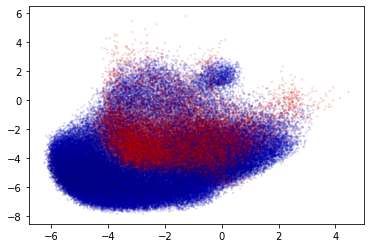

In [102]:
c = V.PC1
ix = np.abs(c) > 0.002
plt.scatter(*mrna_noharm.obsm['X_umap'][mrna_noharm.uns['keptcells']][ix].T, s=2, alpha=0.1,
           c=c[ix], cmap='seismic', vmin=-max(np.abs(c)), vmax=max(np.abs(c)))

In [151]:
c = V.PC6
d = mrna_noharm
X = d.X[d.uns['keptcells']]
X.shape

(393998, 2865)

In [152]:
c_pos = c.copy(); c_pos[c_pos < np.percentile(c_pos, 20)] = 0
c_neg = -c.copy(); c_neg[c_neg < np.percentile(c_neg, 20)] = 0
corrs_pos = (X - X.mean(axis=0)).T.dot(c_pos - c_pos.mean()) / c_pos.std() / X.std(axis=0) / len(c_pos)
corrs_neg = (X - X.mean(axis=0)).T.dot(c_neg - c_neg.mean()) / c_neg.std() / X.std(axis=0) / len(c_neg)

In [153]:
df_pos = pd.DataFrame(index=d.var.index, data={'corr':corrs_pos})
df_neg = pd.DataFrame(index=d.var.index, data={'corr':corrs_neg})

In [154]:
df_pos.sort_values(by='corr', ascending=False)[:10]

,corr
LIMS1,0.221326
PASK,0.194140
LTB,0.186233
RPL37,0.182833
RPS8,0.177137
CCR7,0.173860
RPS4X,0.172993
RPL22,0.171030
RPS6,0.169244
TPT1,0.167633


In [155]:
df_neg.sort_values(by='corr', ascending=False)[:10]

,corr
GZMK,0.295034
RPS4Y1,0.237507
ANXA1,0.190639
LYAR,0.184463
DUSP2,0.182179
ZFP36L2,0.182085
CCL5,0.181451
DDX3Y,0.169478
IL7R,0.158349
TNFAIP3,0.154023
